<a href="https://colab.research.google.com/github/yajima-yasutoshi/Model/blob/main/20250618/%E3%83%80%E3%82%A4%E3%82%A8%E3%83%83%E3%83%88%E5%95%8F%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##準備

In [ ]:
%%capture
# 最適化ライブラリ python-mip のインストール
!pip install mip

# 日本語の表示環境のインストール
!pip install japanize-matplotlib

import mip # python-mip 本体
import pandas as pd # データフレーム操作
import matplotlib.pyplot as plt # グラフ描画 (Matplotlib)
import seaborn as sns # 高度なグラフ描画 (Seaborn)
import japanize_matplotlib # 日本語化対応

# グラフのスタイル設定
# sns.set_style('whitegrid')
# sns.set(font='IPAexGothic')
# plt.rcParams['font.family'] = 'sans-serif' # デフォルトフォント指定

# ダイエット問題

本講義では、数理計画法の古典的かつ実践的な応用例である「ダイエット問題」を取り上げます。

ダイエット問題とは、必要な栄養基準を満たしながら、食品の購入コストを最小化する組み合わせを見つける問題です。

この問題を通して、線形計画問題の定式化、Pythonの最適化ライブラリ `python-mip` を用いた実装方法、そして結果の解釈について学びます。

**学習目標:**

* ダイエット問題を、線形計画問題として定式化できる。
* ダイエット問題を、`python-mip` を用いて線形計画問題を実装し解を求めることができる。
* 最適化モデルの求解結果を解釈し、意思決定に役立てる視点を理解する。


## 問題設定

ある人が1日に摂取すべき栄養素の最小限度量を満たしつつ、食費を最小に抑えたいと考えています。利用可能な食品とその単位あたりのコスト、含まれる栄養素（カロリー、タンパク質、カルシウム）の量は以下の表の通りであるとします。（**注意**：数値は架空のものです。）

**食品データ:**

| 食品名     | 単位   | コスト (円) | カロリー (kcal) | タンパク質 (g) | カルシウム (mg) |
| :--------- | :----- | ----------: | --------------: | -------------: | --------------: |
| 牛乳       | 100ml  |          20 |              60 |              3 |             110 |
| 卵         | 1個    |          30 |              80 |              6 |              30 |
| パン       | 1枚    |          40 |             120 |              4 |              20 |
| チーズ     | 20g    |          50 |              80 |              5 |             140 |
| オレンジ   | 1個    |          60 |              50 |              1 |              40 |

**1日の最小栄養基準:**

| 栄養素     | 最小摂取量 | 単位   |
| :--------- | ---------: | :----- |
| カロリー   |        500 | kcal   |
| タンパク質 |         25 | g      |
| カルシウム |        400 | mg     |

この情報を基に、どの食品をどれだけ摂取すれば、栄養基準を満たしつつコストを最小化できるかを求めます。

## 定式化

この問題を数理計画問題として定式化します。

**集合:**

* 食品（food）の集合 $F = \{ \text{牛乳, 卵, パン, チーズ, オレンジ} \}$
* 栄養素（nutrient）の集合 $N = \{ \text{カロリー, タンパク質, カルシウム} \}$

**定数（パラメータ）:**

* $c_j$: 食品 $j \in F$ の単位あたりのコスト
* $a_{ij}$: 食品 $j \in F$ の単位あたりに含まれる栄養素 $i \in N$ の量
* $b_i^{\min}$: 栄養素 $i \in N$ の最小必要摂取量

**変数:**

* $x_j$: 食品 $j \in F$ の摂取量（単位）。

ただし、食品の量なので非負（マイナスにならない） $x_j \ge 0$ である必要があります。**非負制約**と呼ばれます。

**目的関数:**

総コストを最小化します。
$$\min \sum_{j \in F} c_j x_j$$

**制約条件:**

各栄養素について、摂取量が最小基準を満たす必要があります。
例えば、カロリーに関する最低量の制約条件は
$$
a_{牛乳,カロリー}x_{牛乳} + a_{卵,カロリー}x_{卵} +
a_{バン,カロリー}x_{パン} + a_{チーズ,カロリー}x_{チーズ} +
a_{オレンジ,カロリー}x_{オレンジ} \ge b_{カロリー}^{min}
$$
となります。
同様に、タンパク質は、
$$
a_{牛乳,タンパク質}x_{牛乳} + a_{卵,タンパク質}x_{卵} +
a_{バン,タンパク質}x_{パン} + a_{チーズ,タンパク質}x_{チーズ} +
a_{オレンジ,タンパク質}x_{オレンジ} \ge b_{タンパク質}^{min}
$$
となり、カルシウムに関しても不等式を作ります。

これらをまとめて書くと、以下の通りです。
$$
\sum_{j \in F} a_{ij} x_j \ge b_i^{\min} \quad (\forall i \in N)
$$
また、各食品の摂取量は非負である必要があります。
$$x_j \ge 0 \quad (\forall j \in F)$$
これは線形計画問題 (Linear Programming: LP) と呼ばれる種類の最適化問題です。

## Python MIP による実装

それでは、`python-mip` を用いてこの問題を実装する。

**1. データの準備**

まず、問題を解くために必要なデータを、
`pandas` DataFrame を使い準備する。

In [ ]:
# 食品データの作成
data = {
    '食品名': ['牛乳', '卵', 'パン', 'チーズ', 'オレンジ'],
    '単位': ['100ml', '1個', '1枚', '20g', '1個'],
    'コスト': [20, 30, 40, 50, 60],
    'カロリー': [60, 80, 120, 80, 50],
    'タンパク質': [3, 6, 4, 5, 1],
    'カルシウム': [110, 30, 20, 140, 40]
}
food_df = pd.DataFrame(data)
food_df = food_df.set_index('食品名') # 食品名をインデックスにする

# 栄養基準データの作成
min_requirements = {
    'カロリー': 500,
    'タンパク質': 25,
    'カルシウム': 400
}

# データの確認
print("--- 食品データ ---")
print(food_df)
print("\n--- 最小栄養基準 ---")
print(pd.Series(min_requirements, name='最小摂取量'))

# MIPで扱いやすい形式に変換
foods = food_df.index.tolist()
costs = food_df['コスト'].to_dict()
nutrients = ['カロリー', 'タンパク質', 'カルシウム']
nutrient_values = food_df[nutrients].to_dict('index') # 各食品の栄養価
# {食品名: {栄養素名: 値, ...}, ...} の形式に変換
for food in nutrient_values:
    nutrient_values[food] = {nut: nutrient_values[food][nut] for nut in nutrients}

print("\n--- MIP用データ形式")
print("食品リスト:", foods)
print("コスト:", costs)
print("栄養価 (牛乳):", nutrient_values['牛乳'])
print("最小栄養基準:", min_requirements)

--- 食品データ ---
         単位  コスト  カロリー  タンパク質  カルシウム
食品名                                 
牛乳    100ml   20    60      3    110
卵        1個   30    80      6     30
パン       1枚   40   120      4     20
チーズ     20g   50    80      5    140
オレンジ     1個   60    50      1     40

--- 最小栄養基準 ---
カロリー     500
タンパク質     25
カルシウム    400
Name: 最小摂取量, dtype: int64

--- MIP用データ形式
食品リスト: ['牛乳', '卵', 'パン', 'チーズ', 'オレンジ']
コスト: {'牛乳': 20, '卵': 30, 'パン': 40, 'チーズ': 50, 'オレンジ': 60}
栄養価 (牛乳): {'カロリー': 60, 'タンパク質': 3, 'カルシウム': 110}
最小栄養基準: {'カロリー': 500, 'タンパク質': 25, 'カルシウム': 400}


**2. モデルの作成準備**

`python-mip` で最適化モデルのインスタンスを初期化します。

In [ ]:
# モデルのインスタンス作成(最小化問題)
m = mip.Model(name="DietProblem", sense=mip.MINIMIZE)

**3. 変数の定義**

各食品の摂取量を表す変数を定義します。摂取量は連続値（非負の実数）として扱います。

In [ ]:
# 変数の定義 (各食品の摂取量 x_j >= 0)
# VarType.CONTINUOUS は連続変数を意味する
x = {j: m.add_var(name=f"x_{j}", var_type=mip.CONTINUOUS, lb=0.0) for j in foods}

**4. 目的関数の設定**

総コストを最小化する目的関数を設定します。

In [ ]:
# 目的関数: Σ (コスト_j * 摂取量_j)
m.objective = mip.xsum(costs[j] * x[j] for j in foods)

print("--- 設定された目的関数 ---")
print(m.objective)

--- 設定された目的関数 ---
+ 20.0x_牛乳 + 30.0x_卵 + 40.0x_パン + 50.0x_チーズ + 60.0x_オレンジ 


**5. 制約条件の追加**

各栄養素の最小摂取量に関する制約を追加します。

In [ ]:
# 制約条件: Σ (栄養価_ij * 摂取量_j) >= 最小基準_i
for i in nutrients:
    m.add_constr(
        mip.xsum(nutrient_values[j][i] * x[j] for j in foods) >= min_requirements[i],
        name=f"Nutrient_{i}"
    )

print("\n--- 追加された制約 ---")
#print(m.constrs[0]) # 例として最初の制約（カロリー）を表示
for i in range(len(nutrients)):
  print(m.constrs[i])


--- 追加された制約 ---
Nutrient_カロリー: +60.0 x_牛乳 +80.0 x_卵 +120.0 x_パン +80.0 x_チーズ +50.0 x_オレンジ >= 500.0
Nutrient_タンパク質: +3.0 x_牛乳 +6.0 x_卵 +4.0 x_パン +5.0 x_チーズ +1.0 x_オレンジ >= 25.0
Nutrient_カルシウム: +110.0 x_牛乳 +30.0 x_卵 +20.0 x_パン +140.0 x_チーズ +40.0 x_オレンジ >= 400.0


**6. 求解**

モデルの定義が完了したので、最適化ソルバーを実行して解を求めます。

In [ ]:
# 最適化の実行
status = m.optimize()

# 求解結果のステータスの確認
print("\n--- 求解ステータス ---")
if status == mip.OptimizationStatus.OPTIMAL:
    print("最適解が見つかりました。")
elif status == mip.OptimizationStatus.FEASIBLE:
    print("実行可能解が見つかりました (最適ではない可能性あり)。")
elif status == mip.OptimizationStatus.INFEASIBLE:
    print("実行不可能: 制約を満たす解が存在しません。")
elif status == mip.OptimizationStatus.UNBOUNDED:
    print("非有界: 目的関数を無限に改善可能です。")
else:
    print(f"ソルバーが停止しました。ステータス: {status}")


--- 求解ステータス ---
最適解が見つかりました。


## 結果の表示と解釈

最適解が得られた場合、その結果を確認します。

In [ ]:
if status == mip.OptimizationStatus.OPTIMAL or status == mip.OptimizationStatus.FEASIBLE:
    print(f"\n最小コスト: {m.objective_value:.2f} 円")

    print("\n--- 各食品の最適摂取量 ---")
    results = []
    for j in foods:
        if x[j].x > 1e-6: # ごく小さい値は無視する
            print(f"{j}: {x[j].x:.2f} {food_df.loc[j, '単位']}")
            results.append({'食品名': j, '摂取量': x[j].x, '単位': food_df.loc[j, '単位']})
        else:
            print(f"{j}: 0.00 {food_df.loc[j, '単位']}") # 摂取しない食品も表示

    results_df = pd.DataFrame(results).set_index('食品名')



最小コスト: 166.67 円

--- 各食品の最適摂取量 ---
牛乳: 8.33 100ml
卵: 0.00 1個
パン: 0.00 1枚
チーズ: 0.00 20g
オレンジ: 0.00 1個


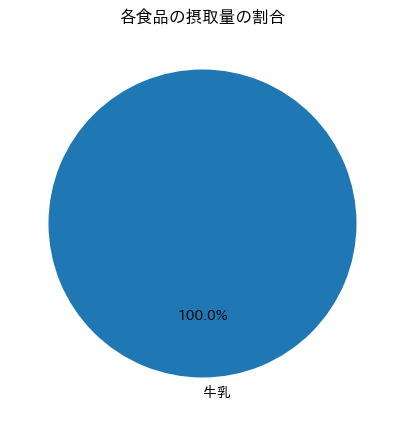


--- 摂取栄養素量と基準の比較 ---


       最小基準         摂取量
カロリー    500  500.000000
タンパク質    25   25.000000
カルシウム   400  916.666667


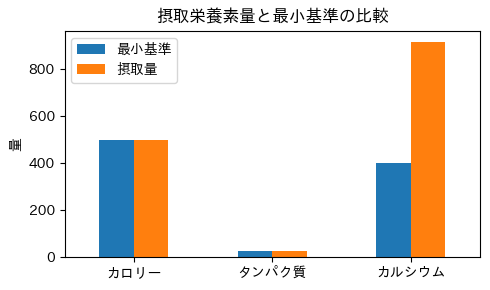


--- 有効な制約（取得栄養素量が基準値とほぼ等しい） ---
栄養素 カロリー の制約は有効です (摂取量 = 基準値)
栄養素 タンパク質 の制約は有効です (摂取量 = 基準値)


In [ ]:
#@title 結果の可視化
if status == mip.OptimizationStatus.OPTIMAL or status == mip.OptimizationStatus.FEASIBLE:
    # 結果の可視化 (摂取量の割合 - 円グラフ)
    if not results_df.empty:
        plt.figure(figsize=(5, 5))
        plt.pie(results_df['摂取量'], labels=results_df.index, autopct='%1.1f%%', startangle=90)
        plt.title('各食品の摂取量の割合')
        plt.ylabel('') # y軸ラベルを非表示に
        plt.show()

    # 摂取される総栄養素量の計算と基準との比較
    print("\n--- 摂取栄養素量と基準の比較 ---")
    total_nutrients = {i: 0 for i in nutrients}
    for j in foods:
        if x[j].x > 1e-6:
            for i in nutrients:
                total_nutrients[i] += nutrient_values[j][i] * x[j].x


    comparison_df = pd.DataFrame({
        '最小基準': pd.Series(min_requirements),
        '摂取量': pd.Series(total_nutrients)
    })
    print("\n")
    print(comparison_df)

    # 比較結果の可視化 (棒グラフ)
    comparison_df.plot(kind='bar', figsize=(5,3))
    plt.title('摂取栄養素量と最小基準の比較')
    plt.ylabel('量')
    plt.xticks(rotation=0)
    plt.tight_layout() # ラベルが重ならないように調整
    plt.show()

    # どの制約が有効か（等号が成立しているか）を確認
    print("\n--- 有効な制約（取得栄養素量が基準値とほぼ等しい） ---")
    for i in nutrients:
      # 浮動小数点誤差を考慮して、わずかな差は許容する
      if abs(total_nutrients[i] - min_requirements[i]) < 1e-6:
          print(f"栄養素 {i} の制約は有効です (摂取量 = 基準値)")

else:
    print("\n最適解が見つからなかったため、結果を表示できません。")


**解釈:**

* **最小コスト:** 最適化によって得られた、栄養基準を満たすための最小の食費が表示されます。
* **最適摂取量:** どの食品をどれだけ摂取すれば最小コストを達成できるかを示します。ゼロの食品は摂取する必要がないことを意味します。
* **摂取栄養素量と基準の比較:** 各栄養素が最小基準をどれだけ満たしているか（または上回っているか）を示します。
* **有効な制約:** 摂取量がちょうど最小基準値と等しくなっている栄養素を示します。これらの栄養素がコスト最小化において「ボトルネック」となっている（ギリギリ達成している）ことを意味します。もしこれらの栄養素の基準が緩和されれば、さらにコストを下げられる可能性があります（逆も然り）。

## 実社会での応用例

ダイエット問題は基本的な例ですが、同様の考え方は様々な実社会の問題に応用されています。

* **病院食や学校給食の献立作成:** 栄養バランス、アレルギー、予算などの制約の下で、最適な献立を計画します。
* **家畜の飼料配合:** 家畜の成長に必要な栄養を満たしつつ、飼料コストを最小化する原料の配合を決定します。
* **製油所の生産計画:** 原油から様々な石油製品（ガソリン、灯油など）を製造する際に、需要、設備能力、原料コストなどを考慮して利益を最大化する生産計画を立てます。
* **資源配分:** 限られた予算や人員を、効果が最大になるように各プロジェクトや部門に割り当てます。

これらの問題は、より多くの変数や複雑な制約（例えば、整数変数や非線形な関係）を含むことがありますが、基本的な考え方はダイエット問題と同様に、目的関数を最適化（最大化または最小化）する変数の組み合わせを制約条件の下で見つけることです。

## モデルの改善に関する視点

今回作成した基本的なダイエット問題モデルは、さらに現実的な状況に合わせて拡張・改善できます。

* **最大摂取量:** ある食品を食べ過ぎないように、各食品の摂取量に上限を設けることができます。（例: `m.add_constr(x['卵'] <= 2)`）
* **整数変数:** 特定の食品は「食べる(1)」か「食べない(0)」かのどちらか、あるいは「何個食べるか」のように整数単位で考えたい場合があります。この場合、変数の型を `INTEGER` や `BINARY` に変更し、混合整数計画問題として扱います。（例: 卵は個数単位なので整数変数にする `m.add_var(..., var_type=mip.INTEGER)`）
* **食品の組み合わせ:** 特定の食品の組み合わせを考慮に入れる（例：「パンとチーズは一緒に食べる」など）。これはより複雑な制約条件で表現できます。
* **味や好み:** 単純なコスト最小化だけでなく、味の好み（スコア化して目的関数に加えるなど）や、食事の多様性（摂取する食品の種類数に下限を設けるなど）を考慮に入れることも可能です。
* **データの精度:** より正確な食品データや栄養基準を用いることで、モデルの信頼性が向上します。

これらの改善は、モデルをより複雑にしますが、より現実的で有用な解を得るために重要です。


#演習問題

以下の演習問題に解答せよ。


##演習問題 1:

「牛乳」アレルギーのため、牛乳を摂取できない場合の最小コストを解答せよ。

**考え方:**
この問題を解くには、元のモデルから牛乳の摂取量を強制的に0にします。
そのために、牛乳の摂取量の上限を0にする制約を追加、
あるいは、変数の上限を0に設定する。

## 演習問題 2:

元の問題でタンパク質の最小必要摂取量が 30g に増加した場合の最小コストを解答せよ。


##演習問題 3:

元の問題に対して、
新たに「ヨーグルト」が利用可能になりました。ヨーグルトは 100g あたりコスト 25円、カロリー 90kcal、タンパク質 4g、カルシウム 120mg です。ヨーグルトを追加した場合の最小コストを解答せよ。

**考え方:**
新しい食品「ヨーグルト」のデータを `foods`, `costs`, `nutrient_values` に追加し、モデルを再構築して最適化を行う。

##演習問題 4:

元の問題設定に加えて、「牛乳」の摂取量を最大 2 単位 (200ml) までとする制約を追加した場合の最小コストを解答せよ。

**考え方:**
元のモデルに、特定の変数（牛乳の摂取量 `x['牛乳']`）に対する上限制約 `x['牛乳'] <= 2` を追加する。


##演習問題 5:

元の問題設定に加えて、以下の条件を追加した場合の最小コストを解答せよ。

1.  **カロリーの上限:** 総摂取カロリーは 800 kcal 以下とする。
2.  **カルシウムの上限:** 総摂取カルシウムは 1000 mg 以下とする。
3.  **乳製品からのカロリー比率:** 牛乳とチーズから摂取する総カロリーが、全摂取カロリーの 50% 以下になるようにする。

**考え方:**
この問題では、栄養素の上限制約と、特定のカテゴリ（乳製品）からの栄養素摂取に関する比率の制約を追加します。
比率の制約
$$\frac{\sum_{j \in \text{乳製品}} a_{\text{カロリー}, j} x_j}{\sum_{j \in F} a_{\text{カロリー}, j} x_j} \le 0.5$$
 は、分母を払って線形な制約
 $$ \sum_{j \in \text{乳製品}} a_{\text{カロリー}, j} x_j \le 0.5 \times \sum_{j \in F} a_{\text{カロリー}, j} x_j$$
  と変形できる。
  